# Lesson 5: Large Vision-Language Models (LVLMs)

## Setup

In [1]:
from pathlib import Path
from urllib.request import urlretrieve
from PIL import Image
from IPython.display import display
from utils import encode_image
from utils import (
    prediction_guard_llava_conv, 
    lvlm_inference_with_conversation
)

### Prepare Data

In [2]:
# Image from COCO dataset
url1 = (
    'https://farm4.staticflickr.com/'
    '3300/3497460990_11dfb95dd1_z.jpg'
)
img1_metadata = {
    "link": url1,
    "transcript": (
        "Wow, this trick is amazing!"
    ),        
    "path_to_file": 
        "./shared_data/skateboard.jpg"
}

# an image and transcript extracted in Lesson 3
img2_metadata = {
    "transcript": (
        "As I look back on the the mission that "
        "we've had here on the International Space Station, "
        "I'm proud to have been a part of much of the "
        "science activities that happened over the last two months."
    ),
    "path_to_file": 
        "./shared_data/videos/video1/extracted_frame/frame_1.jpg"
}

In [3]:
# another image an transcript extracted in Lesson 3
img3_metadata = {
    "transcript": (
        "the science activities that happened over the last "
        "two months. The view is always amazing I didn't think "
        "I would do another spacewalk and to now have the chance "
        "to have done four more was just icing on the cake for a"
    ),
    "path_to_file": 
        "./shared_data/videos/video1/extracted_frame/frame_5.jpg"
}

# download image 1
if not Path(img1_metadata['path_to_file']).exists():
    _ = urlretrieve(
            img1_metadata['link'], 
            img1_metadata['path_to_file']
    )

## LLaVA

- [LLaVA](https://llava-vl.github.io/) (Large Language-and-Vision Assistant), an end-to-end trained large multimodal model that connects a vision encoder and LLM for general-purpose visual and language understanding.
- LLaVA doesn't just see images but understands them, reads the text embedded in them, and reasons about their context—all while conversing with you in a way that feels almost natural.
- LLaVA is adept at tasks like explaining a complex chart, recognizing and reading text in photos, or identifying intricate details in high-resolution images.


<p style="background-color:#fff1d7; padding:15px; "> <b>Note:</b>
<br>
* The first user's message of a conversation must include a text prompt and a base64-encoded image.
<br>  
* The follow-up user's or assistant's messages of a conversation must include a text prompt only.
</p>

### Helper functions

We have provided a dataclass `prediction_guard_llava_conv` and a helper function `lvlm_inference_with_conversation` in `utils.py` to support calling chat completion endpoint of PredictionGuard with a conversation. You can view utils.py using `file`->`open`.

## Few Use Cases with Chat Completion with LLaVA
### Image Captioning

In [4]:
# prepare the prompt and image
prompt = "Please describe the image in detail"
image_path = img2_metadata['path_to_file']
b64_img = encode_image(image_path)

# prepare conversation
img_captioning_conv = prediction_guard_llava_conv.copy()
img_captioning_conv.append_message('user', [prompt, b64_img])
# call chat completion endpoint from prediction guard
caption = lvlm_inference_with_conversation(img_captioning_conv)

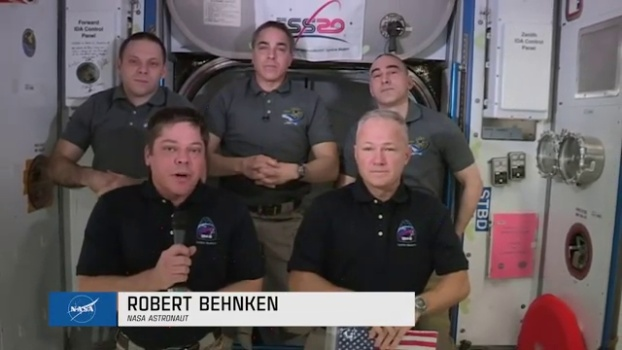



The image features a group of five men wearing blue shirts, standing together in a space shuttle. They appear to be in a relaxed and comfortable environment, possibly discussing their mission or preparing for takeoff. 

Each man is wearing a watch, with one watch on the left wrist, one on the right wrist, and three on the left side of their bodies. The men are standing in a line, with one man standing slightly behind the others. The scene captures the camaraderie and teamwork among the astronauts.


In [5]:
# display caption and image
display(Image.open(image_path))
print(caption)

### QnA on Visual Cues on Images

In [6]:
# prepare the prompt and image
prompt = "What is likely going to happen next?"
image_path = img1_metadata['path_to_file']
b64_img = encode_image(image_path)

# prepare conversation
qna_visual_cues_conv = prediction_guard_llava_conv.copy()
qna_visual_cues_conv.append_message('user', [prompt, b64_img])
# call chat completion endpoint from prediction guard
answer = lvlm_inference_with_conversation(qna_visual_cues_conv)

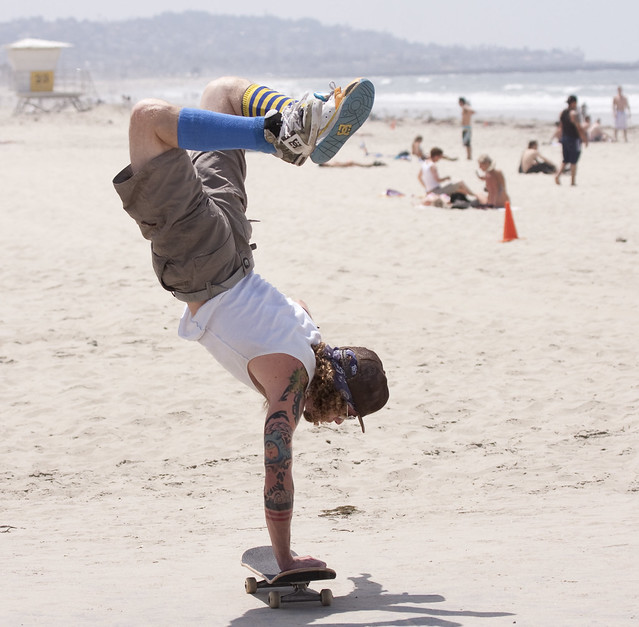



In the image, a man is performing a handstand on a skateboard at the beach. It is likely that he will lose his balance and fall off the skateboard, as handstands are challenging and require a significant amount of strength and coordination. The man's position on the skateboard and the fact that he is at the beach suggest that he might be attempting a trick or simply having fun, but the risk of falling is present.


In [7]:
# display image and answer
display(Image.open(image_path))
print(answer)

### QnA on Textual Cues on Images

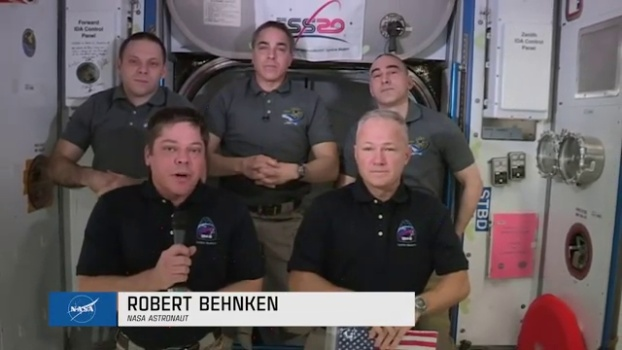

One of the astronauts is named Robert Behnken.


In [8]:
# prepare the prompt and image
prompt = 'What is the name of one of the astronauts?'
image_path = img2_metadata['path_to_file']
b64_img = encode_image(image_path)

# prepare conversation
qna_textual_cues_conv = prediction_guard_llava_conv.copy()
qna_textual_cues_conv.append_message('user', [prompt, b64_img])
# call chat completion endpoint from prediction guard
answer = lvlm_inference_with_conversation(qna_textual_cues_conv)

# display image and answer
display(Image.open(image_path))
print(answer)

### QnA on Caption/Transcript Associated with Images

In [9]:
# prepare the prompt and image
# include the transcript of the image in the prompt
prompt_template = (
    "The transcript associated with the image is '{transcript}'. "
    "What do the astronauts feel about their work?"
)
prompt = prompt_template.format(
    transcript=img2_metadata["transcript"]
)
image_path = img2_metadata['path_to_file']
b64_img = encode_image(image_path)

# prepare conversation
qna_transcript_conv = prediction_guard_llava_conv.copy()
qna_transcript_conv.append_message('user', [prompt, b64_img])
# call chat completion endpoint from prediction guard 
#  with temperature = 0.95 and top_k =2 
#  to reduce randomness in LLaVA's response 
answer = lvlm_inference_with_conversation(
    qna_transcript_conv, 
    temperature=0.95, 
    top_k=2
)

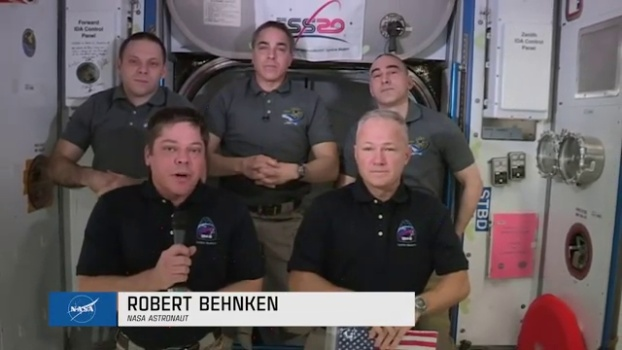

Prompt: The transcript associated with the image is 'As I look back on the the mission that we've had here on the International Space Station, I'm proud to have been a part of much of the science activities that happened over the last two months.'. What do the astronauts feel about their work?
Answer:
The astronauts in the image appear to be proud of their work on the International Space Station. They are all wearing shirts and ties, which suggests a professional and formal atmosphere. One of the astronauts is holding a microphone, indicating that they might be discussing their experiences or sharing information with the public. The fact that they are all smiling and posing for a picture together suggests that they are comfortable with each other and are likely enjoying their time on the space station.


In [10]:
# display image and answer
display(Image.open(image_path))
print(f"Prompt: {prompt}")
print("Answer:")
print(answer)

### Multi-Turn QnA

In [11]:
# extend conversation with the response of LVLM
qna_transcript_conv.append_message('assistant', [answer])

# extend conversation with a follow-up query
follow_up_query = "Where did the astronauts return from?"
qna_transcript_conv.append_message('user', [follow_up_query])

# call chat completion endpoint from prediction guard
follow_up_ans = lvlm_inference_with_conversation(qna_transcript_conv)

In [12]:
# display answer to the second turn
print("Answer to the follow-up query:")
print(follow_up_ans)

Answer to the follow-up query:

The astronauts in the image returned from the International Space Station.
